In [6]:
from functools import partial
import torch
import torch.nn as nn
from timm.models.vision_transformer import PatchEmbed, Block
from util.pos_embed import get_2d_sincos_pos_embed

In [177]:
class MaskedAutoencoderViT(nn.Module):
    def __init__(self, img_size = 224, patch_size=16, en_embed_dim=768, en_depth=12, en_num_heads=12,
        dc_embed_dim=512, dc_depth=8, dc_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), in_chans = 3):
        super().__init__()
        # ===================================================================
        embed_dim = en_embed_dim
        depth = en_depth
        num_heads = en_num_heads
        # ------------------------------ PatchEmbed ---------------
        self.en_patch_embed = PatchEmbed(img_size, patch_size, in_chans = in_chans, embed_dim = embed_dim) 
        num_patches = self.en_patch_embed.num_patches
        # ------------------------------ class token ---------------
        self.en_cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        torch.nn.init.normal_(self.en_cls_token, std=.02)
        # ------------------------------ Positional embed ----------
        self.en_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding
        # ------------------------------ Encoder --- ---------------
        self.en_blocks = nn.ModuleList([
            Block(dim = embed_dim, num_heads = num_heads, mlp_ratio = mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth)])
        # ------------------------------ normal layer --------------
        self.en_norm = norm_layer(embed_dim)
        # ------------------------------ head --------------
        # ===================================================================
        self.dc_embed = nn.Linear(in_features = en_embed_dim, out_features = dc_embed_dim, bias=True)
        # ===================================================================
        embed_dim = dc_embed_dim
        depth = dc_depth
        num_heads = dc_num_heads
        self.num_classes = patch_size**2 * in_chans
        depth = dc_depth
        # ------------------------------ class token ---------------
        self.dc_cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        torch.nn.init.normal_(self.dc_cls_token, std=.02)
        # ------------------------------ Positional embed ----------
        self.dc_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding
        # ------------------------------ Encoder --- ---------------
        self.dc_blocks = nn.ModuleList([
            Block(dim = embed_dim, num_heads = num_heads, mlp_ratio = mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth)])
        # ------------------------------ normal layer --------------
        self.dc_norm = norm_layer(embed_dim)
        # ------------------------------ head --------------
        self.dc_head = nn.Linear(embed_dim, self.num_classes, bias=True) if self.num_classes > 0 else nn.Identity()
        
        self.init()
        
    def en_forward(self, x):
        x = self.en_patch_embed(x)
        x = x + self.en_pos_embed[:, 1:, :]
        #--------- masking --
        #--------------------
        #cls_token = self.en_cls_token + self.en_pos_embed[:, 0, :]
        #cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        #x = torch.cat((cls_tokens, x), dim=1)
        #------- alternatinve ---
        cls_tokens = self.en_cls_token.expand(x.shape[0], -1, -1)  
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.en_pos_embed  
        for block in self.en_blocks:
            x = block(x)
        x = self.en_norm(x)
        return x
    
    def dc_forward(self, x):
        x = self.dc_embed(x)
        #---------- masking 
        #---------
        x = x + self.dc_pos_embed 
        for block in self.dc_blocks:
            x = block(x)
        x = self.dc_norm(x)
        x = self.dc_head(x)
        return x
    
    def forward(self):
        pass
        
    
    def init(self):
        en_pos_embed = get_2d_sincos_pos_embed(self.en_pos_embed.shape[-1], int(self.en_patch_embed.num_patches**.5), cls_token=True)
        self.en_pos_embed.data.copy_(torch.from_numpy(en_pos_embed).float().unsqueeze(0))
        dc_pos_embed = get_2d_sincos_pos_embed(self.dc_pos_embed.shape[-1], int(self.en_patch_embed.num_patches**.5), cls_token=True)
        self.dc_pos_embed.data.copy_(torch.from_numpy(dc_pos_embed).float().unsqueeze(0))     
        ####### do we need to initialise conv_2d in PatchEmbed
        self.apply(self._init_weights)
        
        #self.en_pos_embed = build_2d_sincos_position_embedding(*self.en_pos_embed.shape, self.en_pos_embed.shape[-1])
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


        

In [179]:
test = MaskedAutoencoderViT()
x = torch.randn(1, 3, 224, 224)
y = test.en_forward(x)
z = test.dc_forward(y)
y.shape, z.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

In [159]:
y1 = test.dc_embed(y)
y1.shape, test.dc_pos_embed.shape

(torch.Size([1, 197, 512]), torch.Size([1, 197, 512]))

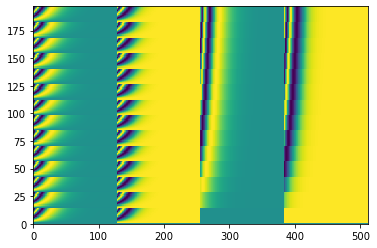

In [119]:
plt.pcolor(test.dc_pos_embed[0].detach().numpy())

In [130]:
test.dc_pos_embed[0][0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

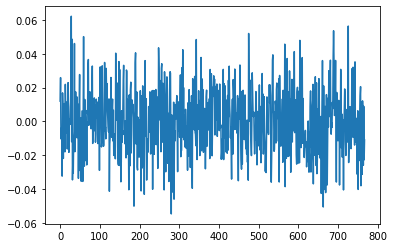

In [127]:
plt.plot(test.en_cls_token.squeeze().detach().numpy())

In [47]:
x = torch.randn(1, 3, 224, 224)

In [90]:
test.en_pos_embed.shape

torch.Size([1, 197, 768])

In [131]:
test.en_cls_token.shape


torch.Size([1, 1, 768])

In [77]:
y1 = test.en_patch_embed(x)
print(y1.shape)
y1 = y1.detach().numpy()

torch.Size([1, 196, 768])


In [88]:
int(test.en_patch_embed.num_patches**.5)

14

In [67]:
import matplotlib.pyplot as plt

In [81]:
y20 = get_2d_sincos_pos_embed(test.en_pos_embed.shape[-1], int(test.en_patch_embed.num_patches**.5), cls_token=True)
y20 = test.en_pos_embed.data.copy_(torch.from_numpy(y20).float().unsqueeze(0))
y20.shape

torch.Size([1, 197, 768])

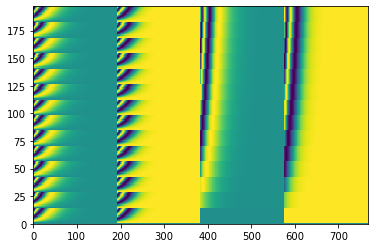

In [69]:
plt.pcolor(y20[0])

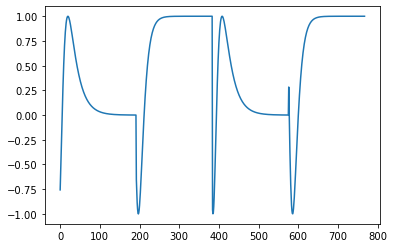

In [87]:
plt.plot(y20[0][75])

In [83]:
y2 = build_2d_sincos_position_embedding(*test.en_pos_embed.shape, 768)
y2.shape

torch.Size([1, 197, 768])

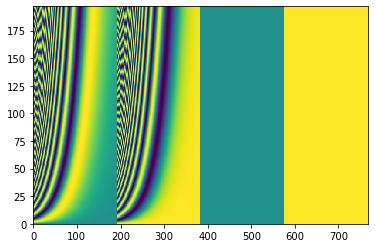

In [84]:
plt.pcolor(y2[0])

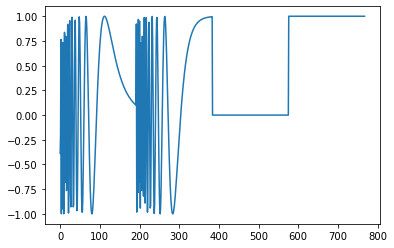

In [86]:
plt.plot(y2[0][75])

In [52]:
test.en_pos_embed.shape

torch.Size([1, 197, 768])

In [35]:
# modiflied from
# https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/Models.py#L31
def get_sinusoid_encoding_table(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    # TODO: make it with torch instead of numpy 
    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)


# modiflied from
# https://github.com/facebookresearch/moco-v3/blob/c349e6e24f40d3fedb22d973f92defa4cedf37a7/vits.py#L53
def build_2d_sincos_position_embedding(h, w, embed_dim=768, temperature=10000.):
    grid_w = torch.arange(w, dtype=torch.float32)
    grid_h = torch.arange(h, dtype=torch.float32)
    grid_w, grid_h = torch.meshgrid(grid_w, grid_h)
    assert embed_dim % 4 == 0, 'Embed dimension must be divisible by 4 for 2D sin-cos position embedding'
    pos_dim = embed_dim // 4
    omega = torch.arange(pos_dim, dtype=torch.float32) / pos_dim
    omega = 1. / (temperature ** omega)
    out_w = torch.einsum('m,d->md', [grid_w.flatten(), omega])
    out_h = torch.einsum('m,d->md', [grid_h.flatten(), omega])
    pos_emb = torch.cat([torch.sin(out_w), torch.cos(out_w), torch.sin(out_h), torch.cos(out_h)], dim=1)[None, :, :]
    return pos_emb
#y2 = build_2d_sincos_position_embedding(*test.en_pos_embed.shape, 768)

In [ ]:
class MaskedAutoencoderViT(nn.Module):
    def __init__(self, patch_size=16, encoder_embed_dim=768, encoder_depth=12, encoder_num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6)):
        super().__init()
        self.encoder = MaskedEncoderViT()
        self.decoder = MaskedDecoderViT()

In [2]:
model = MaskedAutoencoderViT(
        patch_size=16, 
        encoder_embed_dim=768, encoder_depth=12, encoder_num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)

NameError: name 'MaskedAutoencoderViT' is not defined

In [1]:
# class MaskedAutoencoderViT(MaskedAutoencoderViT):
#     def __init__(self,
#                  img_size=224, 
#                  patch_size=16, 
#                  encoder_in_chans=3, 
#                  encoder_num_classes=0, 
#                  encoder_embed_dim=768, 
#                  encoder_depth=12,
#                  encoder_num_heads=12, 
#                  decoder_num_classes=768, 
#                  decoder_embed_dim=512, 
#                  decoder_depth=8,
#                  decoder_num_heads=8, 
#                  mlp_ratio=4., 
#                  qkv_bias=False, 
#                  qk_scale=None, 
#                  drop_rate=0., 
#                  attn_drop_rate=0.,
#                  drop_path_rate=0., 
#                  norm_layer=nn.LayerNorm, 
#                  init_values=0.,
#                  use_learnable_pos_emb=False,):
#         super().__init__()
    
    